## Dependencies

In [1]:
# !pip install --quiet efficientnet
!pip install --quiet image-classifiers

In [2]:
import warnings, json, re
from scripts_step_lr_schedulers import *
from melanoma_utility_scripts import *
from kaggle_datasets import KaggleDatasets
from sklearn.model_selection import KFold
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import optimizers, layers, metrics, losses, Model
# import efficientnet.tfkeras as efn
from classification_models.tfkeras import Classifiers

SEED = 0
seed_everything(SEED)
warnings.filterwarnings("ignore")

## TPU configuration

In [3]:
strategy, tpu = set_up_strategy()
print("REPLICAS: ", strategy.num_replicas_in_sync)
AUTO = tf.data.experimental.AUTOTUNE

REPLICAS:  1


# Model parameters

In [4]:
base_model_path = '/kaggle/input/efficientnet/'
dataset_path = 'melanoma-256x256'

config = {
  "HEIGHT": 256,
  "WIDTH": 256,
  "CHANNELS": 3,
  "BATCH_SIZE": 64,
  "EPOCHS": 15,
  "LEARNING_RATE": 3e-4, 
  "ES_PATIENCE": 5,
  "N_FOLDS": 3,
  "BASE_MODEL_PATH": base_model_path + 'efficientnet-b3_weights_tf_dim_ordering_tf_kernels_autoaugment_notop.h5',
  "DATASET_PATH": dataset_path
}

with open('config.json', 'w') as json_file:
    json.dump(json.loads(json.dumps(config)), json_file)
    
config

{'HEIGHT': 256,
 'WIDTH': 256,
 'CHANNELS': 3,
 'BATCH_SIZE': 64,
 'EPOCHS': 15,
 'LEARNING_RATE': 0.0003,
 'ES_PATIENCE': 5,
 'N_FOLDS': 3,
 'BASE_MODEL_PATH': '/kaggle/input/efficientnet/efficientnet-b3_weights_tf_dim_ordering_tf_kernels_autoaugment_notop.h5',
 'DATASET_PATH': 'melanoma-256x256'}

# Load data

In [5]:
database_base_path = '/kaggle/input/siim-isic-melanoma-classification/'
k_fold = pd.read_csv(database_base_path + 'train.csv')

print('Train samples: %d' % len(k_fold))
display(k_fold.head())

GCS_PATH = KaggleDatasets().get_gcs_path(dataset_path)
TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/train*.tfrec')

Train samples: 33126


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


## Auxiliary functions

In [6]:
# Datasets utility functions
def read_labeled_tfrecord(example, height=config['HEIGHT'], width=config['WIDTH'], channels=config['CHANNELS']):
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'], height, width, channels)
    label = tf.cast(example['target'], tf.float32)
    # meta features
    data = {}
    data['patient_id'] = tf.cast(example['patient_id'], tf.int32)
    data['sex'] = tf.cast(example['sex'], tf.int32)
    data['age_approx'] = tf.cast(example['age_approx'], tf.int32)
    data['anatom_site_general_challenge'] = tf.cast(tf.one_hot(example['anatom_site_general_challenge'], 7), tf.int32)
    data['diagnosis'] = tf.cast(tf.one_hot(example['diagnosis'], 10), tf.int32)
    
    return {'input_image': image, 'input_meta': data}, label # returns a dataset of (image, data, label)

def read_labeled_tfrecord_eval(example, height=config['HEIGHT'], width=config['WIDTH'], channels=config['CHANNELS']):
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'], height, width, channels)
    label = tf.cast(example['target'], tf.float32)
    image_name = example['image_name']
    # meta features
    data = {}
    data['patient_id'] = tf.cast(example['patient_id'], tf.int32)
    data['sex'] = tf.cast(example['sex'], tf.int32)
    data['age_approx'] = tf.cast(example['age_approx'], tf.int32)
    data['anatom_site_general_challenge'] = tf.cast(tf.one_hot(example['anatom_site_general_challenge'], 7), tf.int32)
    data['diagnosis'] = tf.cast(tf.one_hot(example['diagnosis'], 10), tf.int32)
    
    return {'input_image': image, 'input_meta': data}, label, image_name # returns a dataset of (image, data, label, image_name)


def data_augment(image, label):
    p_spatial = tf.random.uniform([1], minval=0, maxval=1, dtype='float32', seed=SEED)
    p_rotate = tf.random.uniform([1], minval=0, maxval=1, dtype='float32', seed=SEED)
    
    ### Spatial-level transforms
    if p_spatial >= .2: # flips
        image['input_image'] = tf.image.random_flip_left_right(image['input_image'], seed=SEED)
        image['input_image'] = tf.image.random_flip_up_down(image['input_image'], seed=SEED)
        if p_spatial >= .7:
            image['input_image'] = tf.image.transpose(image['input_image'])
    if p_rotate >= .8: # rotate 270
        image['input_image'] = tf.image.rot90(image['input_image'], k=3)
    elif p_rotate >= .6: # rotate 180
        image['input_image'] = tf.image.rot90(image['input_image'], k=2)
    elif p_rotate >= .4: # rotate 90
        image['input_image'] = tf.image.rot90(image['input_image'], k=1)

    return image, label


def load_dataset(filenames, ordered=False, buffer_size=-1):
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=buffer_size) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord, num_parallel_calls=buffer_size)
    
    return dataset # returns a dataset of (image, data, label)

def load_dataset_eval(filenames, buffer_size=-1):
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=buffer_size) # automatically interleaves reads from multiple files
    dataset = dataset.map(read_labeled_tfrecord_eval, num_parallel_calls=buffer_size)
    
    return dataset # returns a dataset of (image, data, label, image_name)

def get_training_dataset(filenames, batch_size, buffer_size=-1):
    dataset = load_dataset(filenames, ordered=False, buffer_size=buffer_size)
    dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(batch_size, drop_remainder=True) # slighly faster with fixed tensor sizes
    dataset = dataset.prefetch(buffer_size) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_validation_dataset(filenames, ordered=True, repeated=False, batch_size=32, buffer_size=-1):
    dataset = load_dataset(filenames, ordered=ordered, buffer_size=buffer_size)
    if repeated:
        dataset = dataset.repeat()
        dataset = dataset.shuffle(2048)
    dataset = dataset.batch(batch_size, drop_remainder=repeated)
    dataset = dataset.prefetch(buffer_size)
    return dataset

def get_eval_dataset(filenames, batch_size=32, buffer_size=-1):
    dataset = load_dataset_eval(filenames, buffer_size=buffer_size)
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(buffer_size)
    return dataset

## Learning rate scheduler

Learning rate schedule: 0 to 0.0003 to 3e-05


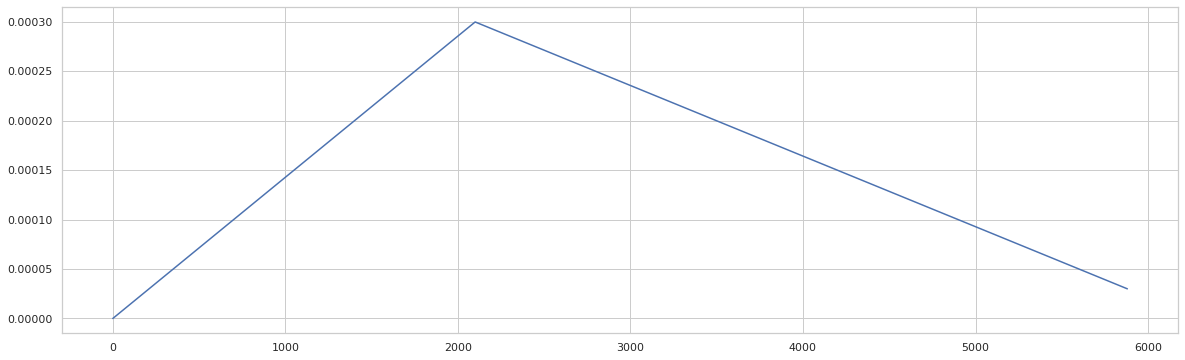

In [7]:
lr_min = 1e-6
lr_start = 0
lr_max = config['LEARNING_RATE']
step_size = 26880 // config['BATCH_SIZE'] #(len(k_fold[k_fold[f'fold_{fold_n}'] == 'train']) * 2) // config['BATCH_SIZE']
total_steps = config['EPOCHS'] * step_size
hold_max_steps = 0
warmup_steps = step_size * 5

rng = [i for i in range(0, total_steps, step_size)]
y = [linear_schedule_with_warmup(tf.cast(x, tf.float32), total_steps=total_steps, 
                                 warmup_steps=warmup_steps, hold_max_steps=hold_max_steps, 
                                 lr_start=lr_start, lr_max=lr_max, lr_min=lr_min) for x in rng]

sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(20, 6))
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

# Model

In [8]:
def model_fn(input_shape):
    input_image = L.Input(shape=input_shape, name='input_image')
    ResNet18, preprocess_input = Classifiers.get('resnet18')
    base_model = ResNet18(input_shape=input_shape, 
                          weights='imagenet', 
                          include_top=False)

    x = base_model(input_image)
    x = L.GlobalAveragePooling2D()(x)
    output = L.Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=input_image, outputs=output)
    
    return model

# Training

In [9]:
eval_dataset = get_eval_dataset(TRAINING_FILENAMES, batch_size=config['BATCH_SIZE'], buffer_size=AUTO)
image_names = next(iter(eval_dataset.unbatch().map(lambda data, label, image_name: image_name).batch(len(k_fold)))).numpy().astype('U')
image_data = eval_dataset.map(lambda data, label, image_name: data)

history_list = []
kfold = KFold(config['N_FOLDS'], shuffle=True, random_state=SEED)
for n_fold, (trn_idx, val_idx) in enumerate(kfold.split(TRAINING_FILENAMES)):
    n_fold +=1
    print('\nFOLD: %d' % (n_fold))
#     tf.tpu.experimental.initialize_tpu_system(tpu)
    K.clear_session()
    
    ### Data
    train_filenames = np.array(TRAINING_FILENAMES)[trn_idx]
    valid_filenames = np.array(TRAINING_FILENAMES)[val_idx]
    train_size = count_data_items(train_filenames)

    step_size = train_size // config['BATCH_SIZE']

    # Train model
    model_path = 'model_fold_%d.h5' % (n_fold)
    
    es = EarlyStopping(monitor='val_loss', mode='min', patience=config['ES_PATIENCE'], 
                       restore_best_weights=True, verbose=1)
    checkpoint = ModelCheckpoint(model_path, monitor='val_loss', mode='min', save_best_only=True, save_weights_only=True)
    
    with strategy.scope():
        model = model_fn((config['HEIGHT'], config['WIDTH'], config['CHANNELS']))
        
        lr = lambda: linear_schedule_with_warmup(tf.cast(optimizer.iterations, tf.float32), 
                                                 total_steps=total_steps, warmup_steps=warmup_steps, 
                                                 hold_max_steps=hold_max_steps, lr_start=lr_start, 
                                                 lr_max=lr_max, lr_min=lr_min)
        
        optimizer = optimizers.Adam(learning_rate=lr)
        model.compile(optimizer, loss=losses.BinaryCrossentropy(label_smoothing=0.1), 
                      metrics=[metrics.AUC()])
    
    history = model.fit(get_training_dataset(train_filenames, batch_size=config['BATCH_SIZE'], buffer_size=AUTO),
                        validation_data=get_validation_dataset(valid_filenames, ordered=True, repeated=False, 
                                                               batch_size=config['BATCH_SIZE'], buffer_size=AUTO),
                        epochs=config['EPOCHS'], 
                        steps_per_epoch=step_size,
                        callbacks=[checkpoint, es],
                        verbose=2).history
    
    history_list.append(history)
    
    # Make predictions
    preds = model.predict(image_data)
    name_preds = dict(zip(image_names, preds.reshape(len(preds))))
    k_fold[f'pred_fold_{n_fold}'] = k_fold.apply(lambda x: name_preds[x['image_name']], axis=1)
    
    valid_filenames = np.array(TRAINING_FILENAMES)[val_idx]
    valid_dataset = get_eval_dataset(valid_filenames, batch_size=config['BATCH_SIZE'], buffer_size=AUTO)
    valid_image_names = next(iter(valid_dataset.unbatch().map(lambda data, label, image_name: image_name).batch(count_data_items(valid_filenames)))).numpy().astype('U')
    k_fold[f'fold_{n_fold}'] = k_fold.apply(lambda x: 'validation' if x['image_name'] in valid_image_names else 'train', axis=1)


FOLD: 1
44924928/44920640 [==============================] - 2s 0us/step
Epoch 1/15
323/323 - 98s - loss: 0.4129 - auc: 0.5839 - val_loss: 0.4657 - val_auc: 0.5189
Epoch 2/15
323/323 - 98s - loss: 0.2430 - auc: 0.8188 - val_loss: 0.2432 - val_auc: 0.4449
Epoch 3/15
323/323 - 97s - loss: 0.2401 - auc: 0.8531 - val_loss: 0.2426 - val_auc: 0.5755
Epoch 4/15
323/323 - 98s - loss: 0.2387 - auc: 0.8676 - val_loss: 0.2387 - val_auc: 0.7612
Epoch 5/15
323/323 - 97s - loss: 0.2371 - auc: 0.8781 - val_loss: 0.2394 - val_auc: 0.7871
Epoch 6/15
323/323 - 97s - loss: 0.2362 - auc: 0.8685 - val_loss: 0.2423 - val_auc: 0.7045
Epoch 7/15
323/323 - 98s - loss: 0.2385 - auc: 0.8698 - val_loss: 0.2395 - val_auc: 0.8059
Epoch 8/15
323/323 - 98s - loss: 0.2344 - auc: 0.8972 - val_loss: 0.2402 - val_auc: 0.7375
Epoch 9/15
Restoring model weights from the end of the best epoch.
323/323 - 98s - loss: 0.2342 - auc: 0.8983 - val_loss: 0.2407 - val_auc: 0.7795
Epoch 00009: early stopping

FOLD: 2
Epoch 1/15
355

## Model loss graph

Fold: 0


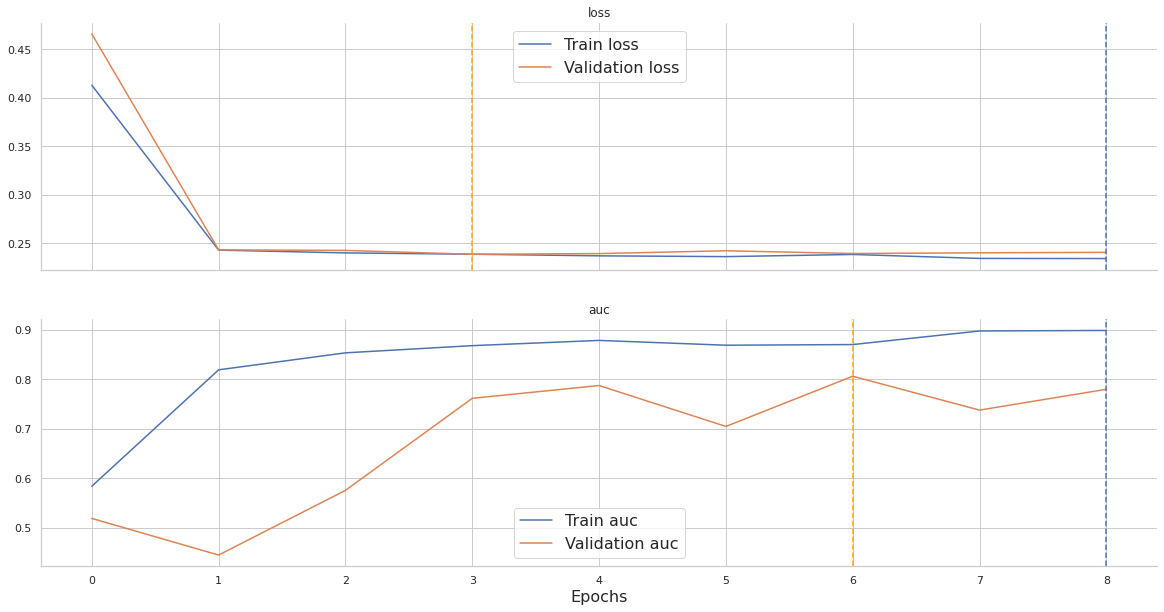

Fold: 1


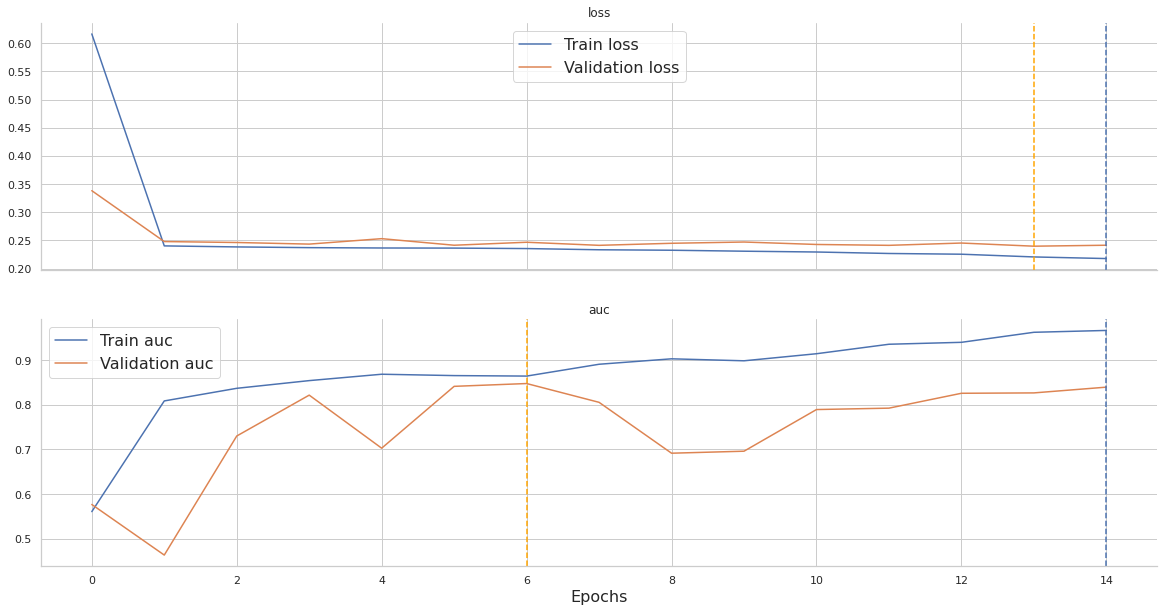

Fold: 2


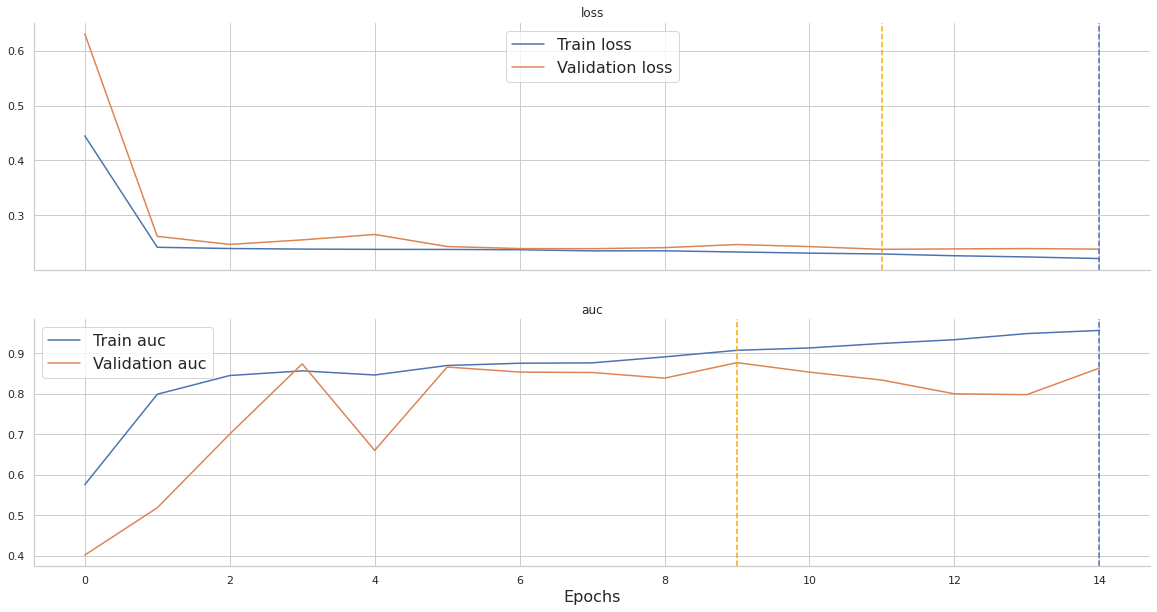

In [10]:
for n_fold in range(config['N_FOLDS']):
    print(f'Fold: {n_fold}')
    plot_metrics(history_list[n_fold])

## Model loss graph aggregated

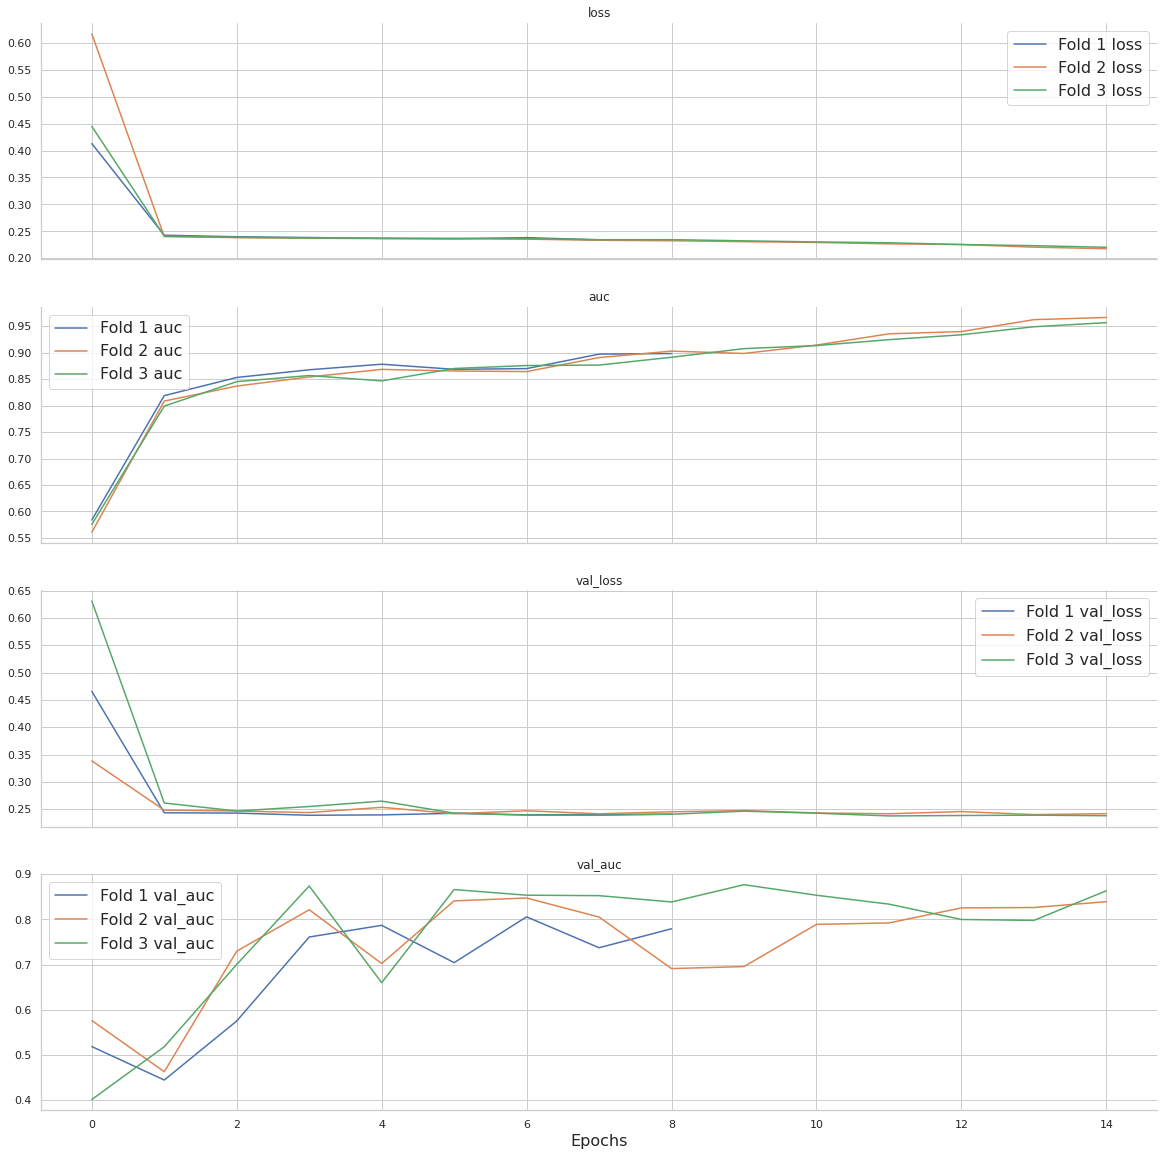

In [11]:
plot_metrics_agg(history_list, config['N_FOLDS'])

# Model evaluation

In [12]:
display(evaluate_model(k_fold, config['N_FOLDS']).style.applymap(color_map))

,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3
Metric,,,,,,,,,
ROC AUC,0.967690,0.821159,0.146530,0.913236,0.761069,0.997077,0.838702,0.992756,0.863706
Accuracy,0.990878,0.981602,0.009275,0.982029,0.983261,0.996401,0.980764,0.994203,0.980782
Precision,0.919945,0.272817,0.647128,0.857143,0.000000,0.981308,0.437500,0.921384,0.380952
Recall,0.518014,0.079748,0.438266,0.015915,0.000000,0.805627,0.108808,0.732500,0.130435
F1-score,0.577412,0.122869,0.454544,0.031250,0.000000,0.884831,0.174274,0.816156,0.194332
Support,389.333333,194.666667,194.666667,377.000000,207.000000,391.000000,193.000000,400.000000,184.000000


# Model evaluation by Subset

In [13]:
display(evaluate_model_Subset(k_fold, config['N_FOLDS']).style.applymap(color_map))

,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3
Subset/ROC AUC,,,,,,,,,
Overall,0.967690,0.821159,0.146530,0.913236,0.761069,0.997077,0.838702,0.992756,0.863706
male,0.971908,0.829968,0.141939,0.926596,0.778314,0.996736,0.842291,0.992391,0.869298
female,0.960810,0.803937,0.156873,0.891971,0.738002,0.997379,0.818255,0.993081,0.855554
head/neck,0.976397,0.813365,0.163032,0.934755,0.829847,0.995365,0.775245,0.999072,0.835004
upper extremity,0.969152,0.816525,0.152627,0.914197,0.706010,0.999288,0.850389,0.993970,0.893175
lower extremity,0.959020,0.773453,0.185567,0.895971,0.707330,0.995613,0.813192,0.985475,0.799836
torso,0.967621,0.840804,0.126817,0.911847,0.786718,0.996817,0.861068,0.994198,0.874625
0 <= age < 26,0.915979,0.712879,0.203100,0.767785,0.772500,0.991379,0.641958,0.988772,0.724179
26 <= age < 40,0.967566,0.792231,0.175335,0.917201,0.680862,0.998341,0.800341,0.987156,0.895490


# Confusion matrix

Fold: 1


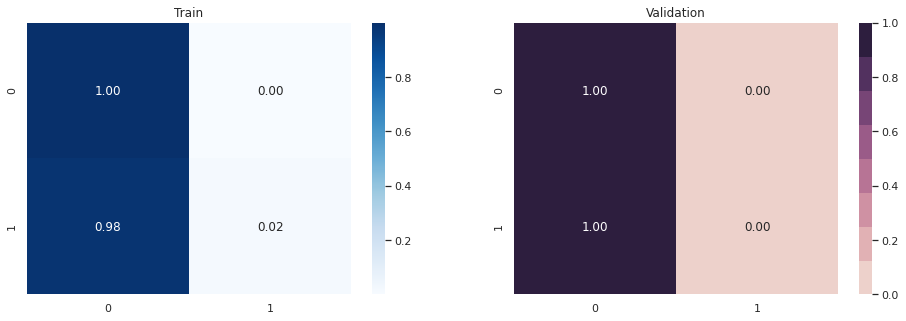

Fold: 2


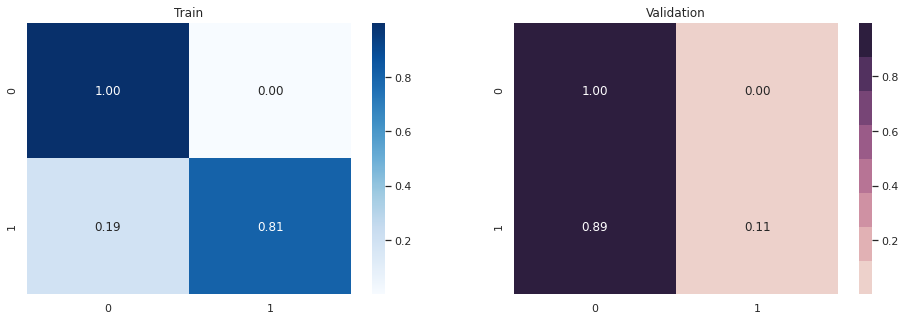

Fold: 3


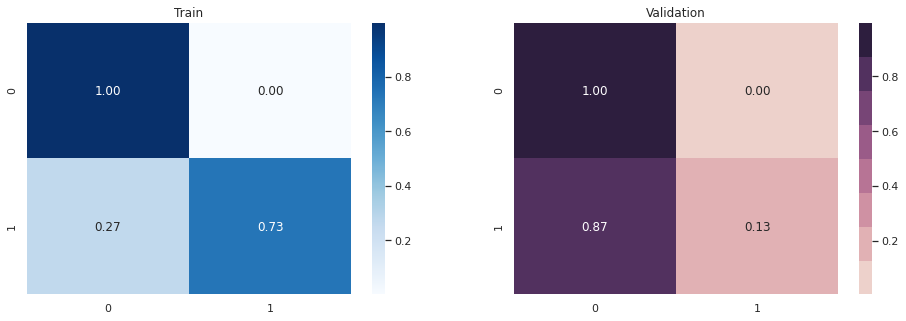

In [14]:
for n_fold in range(config['N_FOLDS']):
    n_fold += 1
    pred_col = f'pred_fold_{n_fold}' 
    train_set = k_fold[k_fold[f'fold_{n_fold}'] == 'train']
    valid_set = k_fold[k_fold[f'fold_{n_fold}'] == 'validation'] 
    print(f'Fold: {n_fold}')
    plot_confusion_matrix(train_set['target'], np.round(train_set[pred_col]),
                          valid_set['target'], np.round(valid_set[pred_col]))

## ROC Curve

Fold: 1


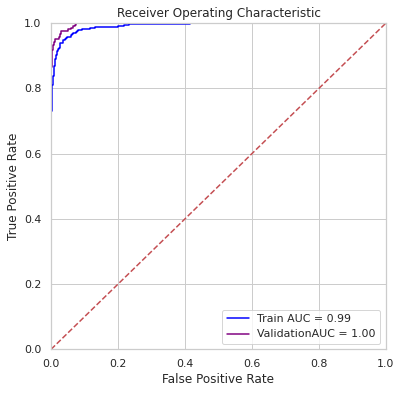

Fold: 2


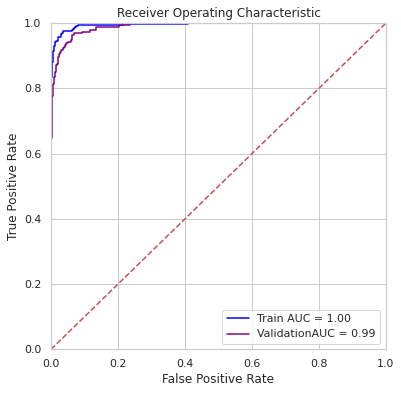

Fold: 3


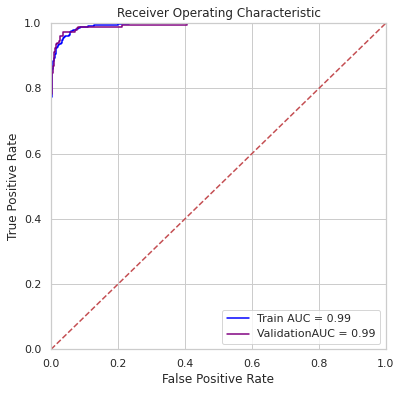

In [15]:
k_fold['pred'] = 0
for n_fold in range(config['N_FOLDS']):
    n_fold +=1
    k_fold['pred'] += k_fold[f'pred_fold_{n_fold}'] / config['N_FOLDS']
    
for n_fold in range(config['N_FOLDS']):
    n_fold += 1
    pred_col = f'pred_fold_{n_fold}' 
    train_set = k_fold[k_fold[f'fold_{n_fold}'] == 'train']
    valid_set = k_fold[k_fold[f'fold_{n_fold}'] == 'validation'] 
    print(f'Fold: {n_fold}')
    
    plot_auc_curve(train_set['target'], train_set['pred'], valid_set['target'], valid_set['pred'])

# Visualize predictions

In [16]:
   
print('Top 10 samples')
display(k_fold[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'diagnosis',
                'target', 'pred'] + [c for c in k_fold.columns if (c.startswith('pred_fold'))]].head(10))

print('Top 10 positive samples')
display(k_fold[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'diagnosis',
                'target', 'pred'] + [c for c in k_fold.columns if (c.startswith('pred_fold'))]].query('target == 1').head(10))


print('Top 10 predicted positive samples')
display(k_fold[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'diagnosis',
                'target', 'pred'] + [c for c in k_fold.columns if (c.startswith('pred_fold'))]].query('pred >= .5').head(10))

Top 10 samples


,image_name,sex,age_approx,anatom_site_general_challenge,diagnosis,target,pred,pred_fold_1,pred_fold_2,pred_fold_3
0,ISIC_2637011,male,45.0,head/neck,unknown,0,0.053730,0.064521,0.049855,0.046814
1,ISIC_0015719,female,45.0,upper extremity,unknown,0,0.047179,0.060313,0.040051,0.041172
2,ISIC_0052212,female,50.0,lower extremity,nevus,0,0.046151,0.054685,0.039339,0.044431
3,ISIC_0068279,female,45.0,head/neck,unknown,0,0.052095,0.044640,0.053424,0.058220
4,ISIC_0074268,female,55.0,upper extremity,unknown,0,0.040239,0.040098,0.042975,0.037643
5,ISIC_0074311,female,40.0,lower extremity,unknown,0,0.058472,0.077444,0.044092,0.053881
6,ISIC_0074542,male,25.0,lower extremity,unknown,0,0.045182,0.047586,0.040843,0.047118
7,ISIC_0075663,female,35.0,torso,unknown,0,0.042174,0.056124,0.036563,0.033835
8,ISIC_0075914,male,30.0,torso,unknown,0,0.041528,0.043576,0.038573,0.042434
9,ISIC_0076262,female,50.0,lower extremity,unknown,0,0.041179,0.037129,0.040071,0.046336


Top 10 positive samples


,image_name,sex,age_approx,anatom_site_general_challenge,diagnosis,target,pred,pred_fold_1,pred_fold_2,pred_fold_3
91,ISIC_0149568,female,55.0,upper extremity,melanoma,1,0.659512,0.036549,0.978638,0.963349
235,ISIC_0188432,female,50.0,upper extremity,melanoma,1,0.686591,0.076435,0.988178,0.995161
314,ISIC_0207268,male,55.0,torso,melanoma,1,0.374215,0.101188,0.065064,0.956393
399,ISIC_0232101,male,65.0,torso,melanoma,1,0.343380,0.089589,0.229499,0.711051
459,ISIC_0247330,female,65.0,lower extremity,melanoma,1,0.672214,0.035639,0.989975,0.991028
475,ISIC_0250839,male,75.0,head/neck,melanoma,1,0.428680,0.144346,0.198994,0.942700
544,ISIC_0272509,female,35.0,lower extremity,melanoma,1,0.104068,0.159204,0.087910,0.065091
546,ISIC_0273046,male,80.0,torso,melanoma,1,0.608368,0.068347,0.947579,0.809178
551,ISIC_0274382,male,65.0,torso,melanoma,1,0.628593,0.095570,0.834456,0.955754
558,ISIC_0275828,male,30.0,lower extremity,melanoma,1,0.562488,0.250560,0.437346,0.999559


Top 10 predicted positive samples


,image_name,sex,age_approx,anatom_site_general_challenge,diagnosis,target,pred,pred_fold_1,pred_fold_2,pred_fold_3
91,ISIC_0149568,female,55.0,upper extremity,melanoma,1,0.659512,0.036549,0.978638,0.963349
235,ISIC_0188432,female,50.0,upper extremity,melanoma,1,0.686591,0.076435,0.988178,0.995161
459,ISIC_0247330,female,65.0,lower extremity,melanoma,1,0.672214,0.035639,0.989975,0.991028
546,ISIC_0273046,male,80.0,torso,melanoma,1,0.608368,0.068347,0.947579,0.809178
551,ISIC_0274382,male,65.0,torso,melanoma,1,0.628593,0.095570,0.834456,0.955754
558,ISIC_0275828,male,30.0,lower extremity,melanoma,1,0.562488,0.250560,0.437346,0.999559
826,ISIC_0351666,male,80.0,head/neck,melanoma,1,0.574730,0.094606,0.657923,0.971662
1332,ISIC_0502582,male,65.0,lower extremity,melanoma,1,0.744463,0.254882,0.997383,0.981123
1335,ISIC_0504165,female,60.0,lower extremity,melanoma,1,0.687042,0.085298,0.977987,0.997841
1423,ISIC_0528044,male,65.0,torso,melanoma,1,0.546577,0.335377,0.986890,0.317465
